In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from pandas import DataFrame
import sqlite3

In [3]:
CACHE_FILE_NAME = 'SI507_Final_Project.json'

In [2]:
def load_cache():
    try:
        cache_file = open(CACHE_FILE_NAME, 'r')
        cache_file_contents = cache_file.read()
        cache = json.loads(cache_file_contents)
        cache_file.close()
    except:
        cache = {}
    return cache

In [4]:
def save_cache(cache):
    cache_file = open(CACHE_FILE_NAME, 'w')
    contents_to_write = json.dumps(cache)
    cache_file.write(contents_to_write)
    cache_file.close()

In [5]:
def make_url_request_using_cache(url, cache,headers='none',params='none'):
    if (url in cache.keys()): 
        print("Using cache")
        return cache[url]
    else:
        print("Fetching")
        response = requests.get(url,headers=headers,params=params)
        cache[url] = response.text
        save_cache(cache)
        return cache[url]

In [6]:
CACHE_DICT = load_cache()

In [7]:
base_url = 'https://spotcrime.com/'
cities = [
    'mi/ann+arbor/',
    'mi/detroit/',
    'mo/st.+louis/',
    'md/baltimore/',
    'oh/toledo/',
    'ga/albany/',
    'mi/flint/',
    'tn/memphis/',
    'pa/philadelphia/',
]

In [8]:
def get_daily(city):
    headers = { 'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36'}
    res = make_url_request_using_cache('https://spotcrime.com/' + city + 'daily-archive',CACHE_DICT,headers)
    soup = BeautifulSoup(res, 'html.parser')
    crime_daily_url_dict={}
    crime_report_daily = soup.find('div', class_='default-page-container')
    crime_report_daily_urls = crime_report_daily.find_all('a',recursive=False)
    for crime_report_daily_url in crime_report_daily_urls:
        #print(crime_report_daily_url)
        #print(crime_report_daily_url.text.strip().lower())
        #print(crime_report_daily_url['href'])
        crime_daily_url_dict[crime_report_daily_url.text.strip().lower()]=base_url+crime_report_daily_url['href']
    return crime_daily_url_dict
    #for state_listing_ul in state_listing_uls:
        #state_url_dict[state_listing_ul.text.strip().lower()]=BASE_URL+state_listing_ul.find('a')['href']
    #return state_url_dict

In [9]:
def specific_daily(dict):
    headers = { 'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36'}
    crime_dict=[]
    for i in dict.keys():
        crime_dict=crime_dict+helper(dict[i])
    #map_dict={'01':'Jan','02':'Feb','03':'Mar','04':'Apr' ,'05':'May','06':'Jun','07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}
    df = pd.DataFrame(crime_dict, columns=['Type', 'Time', 'Location'])
    df['Month']=df['Time'].map(lambda x: x.split()[0].split('/')[0])
    df['Date']=df['Time'].map(lambda x: x.split()[0])
    return df

In [11]:
def helper(url):
    headers = { 'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36'}
    res=make_url_request_using_cache(url,CACHE_DICT,headers)
    soup = BeautifulSoup(res, 'html.parser')
    crime_daily_url_dict={}
    crime_report_daily = soup.find('div', class_='city-page__crimes-container')
    crime_report_daily_urls = crime_report_daily.find_all('a',recursive=False)
    map_dict=a={'01':'Jan','02':'Feb','03':'Mar','04':'Apr' ,'05':'May','06':'Jun','07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}
    a=[]
    for crime_report_daily_url in crime_report_daily_urls:
        a.append([crime_report_daily_url.find('span',class_="city-page__crime-card-title").text.strip(),crime_report_daily_url.find('span',class_="city-page__crime-card-date").text.strip(),crime_report_daily_url.find('span',class_="city-page__crime-card-address").text.strip()])
        
    #df = pd.DataFrame(a, columns=['one', 'two', 'three']) 
    return a

In [12]:
def database_create(database,table):

    conn = sqlite3.connect(database)
    cur = conn.cursor()
    drop_crime = '''
    DROP TABLE IF EXISTS "crime";
'''
    drop_crime_info = '''
    DROP TABLE IF EXISTS "crime_info";
'''

    create_crime = '''
    create table crime
(
	crime_id int not null
		constraint crime_pk
			primary key,
	type text,
	time text
);
  
'''

   
    create_crime_info='''
   create table crime_info
(
	crime_id int not null
		constraint crime_info_pk
			primary key
		constraint crime_info_crime_crime_id_fk
			references crime
				on delete cascade,
	month int,
	date date
);
'''
    
    cur.execute(drop_crime)
    cur.execute(drop_crime_info)
    
    cur.execute(create_crime)
    cur.execute(create_crime_info)
    table1=table.copy()
    table1.reset_index(inplace=True)
    table1.rename(columns={'index':'id'},inplace=True)
    for i in range(table1.shape[0]):
        a=f"INSERT INTO crime VALUES ({int(table1.iloc[i].id)}, '{table1.iloc[i].Type}', '{table1.iloc[i].Time}')"
        
        cur.execute(a)
        print(float(i/table1.shape[0]*100))
    for i in range(table1.shape[0]):
        a=f"INSERT INTO crime_info VALUES ({int(table1.iloc[i].id)}, {table1.iloc[i].Month}, '{table1.iloc[i].Date}')"
        print(a)
        cur.execute(a)

    conn.commit()

In [17]:
def interface():
    while True:
        print('Choose a city of which you are interested in its crime condition?')
        print('1. Ann Arbor   2. Detroit  3. St Louis  4. Baltimore  5. Toledo  6. Albany  7. Exit /n')
        number=input()
        if number=='7':
            break
        city=cities[int(number)-1]
        city_urls=get_daily(city)
        city_df=specific_daily(city_urls)
        
        print(city_df.Type.value_counts().plot(kind='pie'))
        #print(city_df.Location.value_counts().head(10).plot(kind='bar'))
        #print(city_df.groupby('Date').Time.count().plot(kind='line'))
    print('Thanks. Bye.')
    return 

Choose a city of which you are interested in its crime condition?
1. Ann Arbor   2. Detroit  3. St Louis  4. Baltimore  5. Toledo  6. Albany  7. Exit /n
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
Using cache
AxesSubplot(0.398106,0.125;0.228788x0.343182)
AxesSubplot(0.398106,0.125;0.228788x0.343182)
AxesSubplot(0.125,0.151278;0.775x0.290625)
Choose a city of which you are interested in its crime condition?
1. Ann Arbor   2. Detroit  3. St Louis  4. Baltimore  5. Toledo  6. Albany  7. Exit /n
Thanks. Bye.


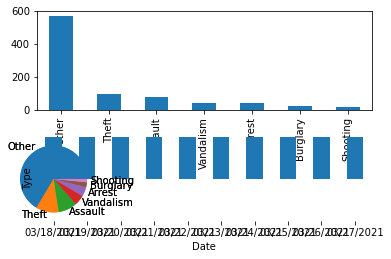

In [16]:
interface()